In [1]:
!pip install transformers
!pip install datasets
!pip install transformers[torch]
%pip install accelerate -U

In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, BertForTokenClassification, Trainer,TrainingArguments
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD
import datasets
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix,ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt
from transformers import AutoModelForTokenClassification

In [4]:
# Reading Dataset for preprocessing
# def read_datasets(path):
#     f = open(path)
#     words= []
#     tags= []
#     word= []
#     tag= []
#     mx = []
#     for line in f.readlines():
#         line= line.split('\t')
#         if len(line)==2:
#             word.append(line[0])
#             tag.append(line[1].strip())
#         else:
#             mx.append(len(word))
#             words.append(word)
#             tags.append(tag)
#             if len(word)!=len(tag):
#                 print(line)
#             word =[]
#             tag = []
#     print(len(words),len(tags))
#     df = pd.DataFrame(columns=["text","labels"])

#     df["text"] = words
#     df["labels"] = tags

#     return words, tags, df



# train_words, train_tags, train_df = read_datasets('final_train.txt')
# val_words, val_tags, val_df = read_datasets('final_val.txt')
# test_words, test_tags, test_df = read_datasets('final_test.txt')

350 350
50 50
100 100


In [ ]:
def read_datasets3(file_path):
    with open(file_path, 'r') as file:
        word_list = []
        tag_list = []
        current_words = []
        current_tags = []
        lengths = []

        for line in file.readlines():
            parts = line.split('\t')
            if len(parts) == 2:
                current_words.append(parts[0])
                current_tags.append(parts[1].strip())
            elif line.strip() == '':
                if len(current_words) != len(current_tags):
                    print("Mismatch found:", line)
                word_list.append(current_words)
                tag_list.append(current_tags)
                lengths.append(len(current_words))
                current_words = []
                current_tags = []

        print(f"Total sentences: {len(word_list)}, Total tags: {len(tag_list)}")

        dataset_df = pd.DataFrame({
            "text": word_list,
            "labels": tag_list
        })

    return word_list, tag_list, dataset_df

In [ ]:

train_words, train_tags, train_df = read_datasets3('final_train.txt')
val_words, val_tags, val_df = read_datasets3('final_val.txt')
test_words, test_tags, test_df = read_datasets3('final_test.txt')

In [5]:
# Defining tags used in dataset
unique_tags = ['O','B-Task', 'I-Task', 'B-Process', 'I-Process', 'B-Material', 'I-Material']
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}
# print("Unique Tags : ", unique_tags)
# print("Tags to ID  : ", tag2id)
# print("ID to Tags : ", id2tag)


tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

Unique Tags :  ['O', 'B-Task', 'I-Task', 'B-Process', 'I-Process', 'B-Material', 'I-Material']
Tags to ID  :  {'O': 0, 'B-Task': 1, 'I-Task': 2, 'B-Process': 3, 'I-Process': 4, 'B-Material': 5, 'I-Material': 6}
ID to Tags :  {0: 'O', 1: 'B-Task', 2: 'I-Task', 3: 'B-Process', 4: 'I-Process', 5: 'B-Material', 6: 'I-Material'}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Generating Encoding for train,val and test words
train_encodings = tokenizer(train_words, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True, max_length=512)
val_encodings = tokenizer(val_words, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True,max_length=512)
test_encodings = tokenizer(test_words, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True,max_length=512)

In [7]:
# Function to encode tags
def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * 0
        arr_offset = np.array(doc_offset)

        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

train_labels = encode_tags(train_tags, train_encodings)
val_labels = encode_tags(val_tags, val_encodings)
test_labels = encode_tags(test_tags, test_encodings)

In [8]:
# Class for SemEval Dataset for encoding and labels
class SemEvalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings.pop("offset_mapping")
val_encodings.pop("offset_mapping")
test_encodings.pop("offset_mapping")

train_dataset = SemEvalDataset(train_encodings, train_labels)
val_dataset = SemEvalDataset(val_encodings, val_labels)
test_dataset = SemEvalDataset(test_encodings, test_labels)

In [9]:
# Fine tuning the model and adding parameters

BATCH_SIZE = 4
EPOCHS = 10
training_args = TrainingArguments(
    output_dir = "Output",
    evaluation_strategy = "no",
    save_strategy = "no",
    learning_rate = 2e-5,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    num_train_epochs = EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=False,
    do_train = True,
    do_eval = True,
    do_predict = True,
   remove_unused_columns = False
)

In [10]:
# Training
model = AutoModelForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=len(unique_tags))
trainer = Trainer(model=model,args=training_args,train_dataset=train_dataset,eval_dataset=val_dataset)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.103300


TrainOutput(global_step=880, training_loss=0.06872814351862128, metrics={'train_runtime': 242.9773, 'train_samples_per_second': 14.405, 'train_steps_per_second': 3.622, 'total_flos': 609124563663000.0, 'train_loss': 0.06872814351862128, 'epoch': 10.0})

In [12]:
# Evaluation
trainer.evaluate()
predictions, labels, metrics = trainer.predict(test_dataset, metric_key_prefix="predict")
y_pred = np.argmax(predictions, 2)
y_pred_fl = y_pred.flatten()
y_true = labels.flatten()

Confusion Matrix : 


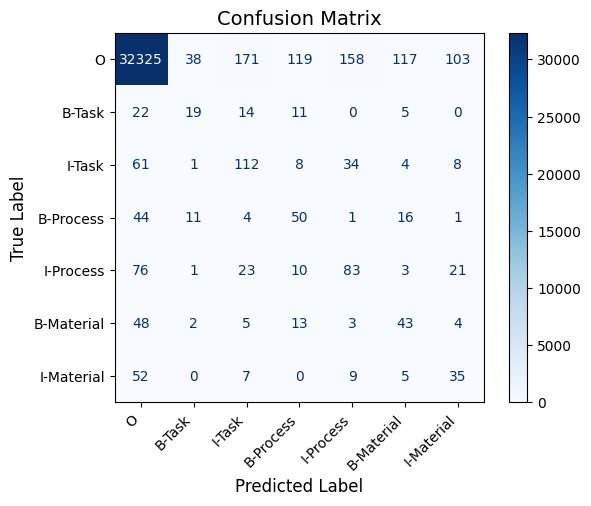

In [14]:
# Confusion matrix
print("Confusion Matrix : ")
cm = confusion_matrix(y_pred_fl, y_true)
display = ConfusionMatrixDisplay(cm, display_labels=unique_tags)
display.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

In [20]:
# Classification Report
cr = classification_report(y_true, y_pred_fl,target_names=unique_tags)
print(cr)

# Class wise Report
#Precision
print()
print("****************************************************************")
print("Precision Score - ")
class_wise = precision_score(y_true, y_pred_fl, average=None)
print("1. Class-wise :")
for i in range(len(class_wise)):
    print("\t", unique_tags[i], "\t", round(class_wise[i],4))
print()
print("2. micro : ", precision_score(y_true, y_pred_fl, average='micro'))
print("3. macro : ", precision_score(y_true, y_pred_fl, average='macro'))

#Recall
print()
print("****************************************************************")
print("Recall Score - ")
class_wise = recall_score(y_true, y_pred_fl, average=None)
print("1. Class-wise :")
for i in range(len(class_wise)):
    print("\t", unique_tags[i], "\t", round(class_wise[i],4))
print()
print("2. micro : ", recall_score(y_true, y_pred_fl, average='micro'))
print("3. macro : ", recall_score(y_true, y_pred_fl, average='macro'))

#F1 Score
print()
print("****************************************************************")
print("F1 Score - ")
class_wise = f1_score(y_true, y_pred_fl, average=None)
print("1. Class-wise :")
for i in range(len(class_wise)):
    print("\t", unique_tags[i], "\t", round(class_wise[i],4))
print()
print("2. micro : ", f1_score(y_true, y_pred_fl, average='micro'))
print("3. macro : ", f1_score(y_true, y_pred_fl, average='macro'))

# Overall accuraccy
print()
print("****************************************************************")
print("Accuracy Score : " ,accuracy_score(y_true, y_pred_fl))

              precision    recall  f1-score   support

           O       0.98      0.99      0.98     32628
      B-Task       0.27      0.26      0.27        72
      I-Task       0.49      0.33      0.40       336
   B-Process       0.39      0.24      0.30       211
   I-Process       0.38      0.29      0.33       288
  B-Material       0.36      0.22      0.28       193
  I-Material       0.32      0.20      0.25       172

    accuracy                           0.96     33900
   macro avg       0.46      0.36      0.40     33900
weighted avg       0.96      0.96      0.96     33900


****************************************************************
Precision Score - 
1. Class-wise :
	 O 	 0.9786
	 B-Task 	 0.2676
	 I-Task 	 0.4912
	 B-Process 	 0.3937
	 I-Process 	 0.3825
	 B-Material 	 0.3644
	 I-Material 	 0.3241

2. micro :  0.9636283185840708
3. macro :  0.457447137637009

****************************************************************
Recall Score - 
1. Class-wise :
	 O 	 0

In [23]:
# from torch import cuda

# # Move model to the appropriate device
# device = 'cuda' if cuda.is_available() else 'cpu'
# model.to(device)

# # Token Classification
# def token_classification(input_text, flag=False):
#     if flag:
#         print("\033[1;31;47mProcess\033[1;32;47m Task\033[1;34;47m Material")
#         print()
#     inputs = tokenizer(input_text, return_tensors="pt")
#     inputs = inputs.to(device)  # Move input data to the same device as the model
#     outputs = model(**inputs)
#     probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
#     predictions = outputs.logits.argmax(dim=-1)[0].tolist()
#     unique_tags = ['O','B-Task', 'I-Task', 'B-Process', 'I-Process', 'B-Material', 'I-Material']
#     ans = [unique_tags[i] for i in predictions]
#     text = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
#     final_output = ""
#     for i in range(len(text)):
#         if flag:
#             if ans[i]=='O':
#                 print("\033[0;30;47m"+text[i]+"\033[0;37;47m", end =" ")
#             elif ans[i]=='B-Process' or ans[i]=='I-Process':
#                 print("\033[1;31;47m"+text[i]+"\033[0;37;47m",end=" ")
#             elif ans[i]=='B-Task' or ans[i]=='I-Task':
#                 print("\033[1;32;47m"+text[i]+"\033[0;37;47m",end=" ")
#             else:
#                 print("\033[1;34;47m"+text[i]+"\033[0;37;47m",end=" ")
#         else:
#             final_output += text[i] + "\t" + ans[i] + "\n"

#     if not flag:
#         return final_output


In [ ]:
import torch
from torch import cuda

# Set up device based on CUDA availability
device = 'cuda' if cuda.is_available() else 'cpu'

# Ensure the model is transferred to the appropriate compute device
model.to(device)

def token_classification(input_text, verbose=False):
    # Tokenize input text and prepare inputs for the model
    inputs = tokenizer(input_text, return_tensors="pt")
    inputs = inputs.to(device)  # Align input tensor device with model's device
    
    # Perform inference
    with torch.no_grad():  # Disable gradient computation for inference
        outputs = model(**inputs)
    
    # Process model outputs
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
    predictions = outputs.logits.argmax(dim=-1)[0].tolist()
    tag_labels = ['O', 'B-Task', 'I-Task', 'B-Process', 'I-Process', 'B-Material', 'I-Material']
    classified_tags = [tag_labels[i] for i in predictions]
    tokenized_text = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Generate output based on the verbose flag
    if verbose:
        # Print each token with its corresponding tag, colored based on the tag type
        for token, tag in zip(tokenized_text, classified_tags):
            color = "\033[0;37;47m"  # Default white
            if tag.startswith('B-Process') or tag.startswith('I-Process'):
                color = "\033[1;31;47m"  # Red for Process
            elif tag.startswith('B-Task') or tag.startswith('I-Task'):
                color = "\033[1;32;47m"  # Green for Task
            elif tag.startswith('B-Material') or tag.startswith('I-Material'):
                color = "\033[1;34;47m"  # Blue for Material
            print(f"{color}{token}\033[0;37;47m", end=" ")
        print()  # Ensure newline at the end of the printout
    else:
        # Concatenate each token with its tag for non-verbose output
        return '\n'.join(f"{token}\t{tag}" for token, tag in zip(tokenized_text, classified_tags))


In [24]:
# Testing
text = '''
The study outlines a trial of transient response analysis on full-scale motorway bridge structures to obtain information concerning the steel–concrete interface and is part of a larger study to assess the long-term sustained benefits offered by Impressed Current Cathodic Protection (ICCP) after the interruption of the protective current [1]. These structures had previously been protected for 5–16years by an ICCP system prior to the start of the study. The protective current was interrupted, in order to assess the long-term benefits provided by ICCP after it has been turned off. This paper develops and examines a simplified approach for the on-site use of transient response analysis and discusses the potential advantages of the technique as a tool for the assessment of the corrosion condition of steel in reinforced concrete structures.
'''
token_classification(text, True)

Process Task Material

[CLS] the study outlines a trial of transient response analysis on full - scale motor ##way bridge structures to obtain information concerning the steel – concrete interface and is part of a larger study to assess the long - term sustained benefits offered by imp ##ressed current cath ##odic protection ( icc ##p ) after the interruption of the protective current [ 1 ] . these structures had previously been protected for 5 – 16 ##years by an icc ##p system prior to the start of the study . the protective current was interrupted , in order to assess the long - term benefits provided by icc ##p after it has been turned off . this paper develops and examines a simplified approach for the on - site use of transient response analysis and discusses the potential advantages of the technique as a tool for the assessment of the corrosion condition of steel in reinforced concrete structures . [SEP] 